In [8]:
import tensorflow as tf

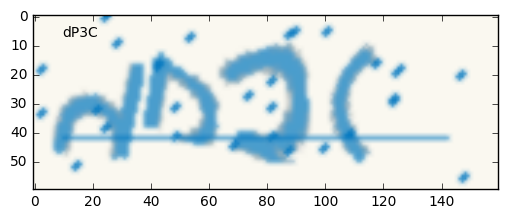

In [1]:
from captcha.image import ImageCaptcha  # pip install captcha
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# 验证码中的字符, 就不用汉字了
number = ['0','1','2','3','4','5','6','7','8','9']
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
ALPHABET = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
# 验证码一般都无视大小写；验证码长度4个字符
def random_captcha_text(char_set=number+alphabet+ALPHABET, captcha_size=4):
	captcha_text = []
	for i in range(captcha_size):
		c = random.choice(char_set)
		captcha_text.append(c)
	return captcha_text

# 生成字符对应的验证码
def gen_captcha_text_and_image():
	image = ImageCaptcha()

	captcha_text = random_captcha_text()
	captcha_text = ''.join(captcha_text)

	captcha = image.generate(captcha_text)
	#image.write(captcha_text, captcha_text + '.jpg')  # 写到文件

	captcha_image = Image.open(captcha)
	captcha_image = np.array(captcha_image)
	return captcha_text, captcha_image

if __name__ == '__main__':
	# 测试
	text, image = gen_captcha_text_and_image()

	f = plt.figure()
	ax = f.add_subplot(111)
	ax.text(0.1, 0.9 ,text, ha='center', va='center', transform=ax.transAxes)
	plt.imshow(image)

	plt.show()

In [2]:
import numpy as np
import tensorflow as tf
 
text, image = gen_captcha_text_and_image()
print "验证码图像channel:", image.shape  # (60, 160, 3)
# 图像大小
IMAGE_HEIGHT = 60
IMAGE_WIDTH = 160
MAX_CAPTCHA = len(text)
print "验证码文本最长字符数", MAX_CAPTCHA   # 验证码最长4字符; 我全部固定为4,可以不固定. 如果验证码长度小于4，用'_'补齐
 
# 把彩色图像转为灰度图像（色彩对识别验证码没有什么用）
def convert2gray(img):
	if len(img.shape) > 2:
		gray = np.mean(img, -1)
		# 上面的转法较快，正规转法如下
		# r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
		# gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
		return gray
	else:
		return img
 
"""
cnn在图像大小是2的倍数时性能最高, 如果你用的图像大小不是2的倍数，可以在图像边缘补无用像素。
np.pad(image,((2,3),(2,2)), 'constant', constant_values=(255,))  # 在图像上补2行，下补3行，左补2行，右补2行
"""
 
# 文本转向量
char_set = number + alphabet + ALPHABET + ['_']  # 如果验证码长度小于4, '_'用来补齐
CHAR_SET_LEN = len(char_set)
def text2vec(text):
	text_len = len(text)
	if text_len > MAX_CAPTCHA:
		raise ValueError('验证码最长4个字符')
 
	vector = np.zeros(MAX_CAPTCHA*CHAR_SET_LEN)
	def char2pos(c):
		if c =='_':
			k = 62
			return k
		k = ord(c)-48
		if k > 9:
			k = ord(c) - 55
			if k > 35:
				k = ord(c) - 61
				if k > 61:
					raise ValueError('No Map') 
		return k
	for i, c in enumerate(text):
		idx = i * CHAR_SET_LEN + char2pos(c)
		vector[idx] = 1
	return vector
# 向量转回文本
def vec2text(vec):
	char_pos = vec.nonzero()[0]
	text=[]
	for i, c in enumerate(char_pos):
		char_at_pos = i #c/63
		char_idx = c % CHAR_SET_LEN
		if char_idx < 10:
			char_code = char_idx + ord('0')
		elif char_idx <36:
			char_code = char_idx - 10 + ord('A')
		elif char_idx < 62:
			char_code = char_idx-  36 + ord('a')
		elif char_idx == 62:
			char_code = ord('_')
		else:
			raise ValueError('error')
		text.append(chr(char_code))
	return "".join(text)
 
"""
#向量（大小MAX_CAPTCHA*CHAR_SET_LEN）用0,1编码 每63个编码一个字符，这样顺利有，字符也有
vec = text2vec("F5Sd")
text = vec2text(vec)
print(text)  # F5Sd
vec = text2vec("SFd5")
text = vec2text(vec)
print(text)  # SFd5
"""
 
# 生成一个训练batch
def get_next_batch(batch_size=128):
	batch_x = np.zeros([batch_size, IMAGE_HEIGHT*IMAGE_WIDTH])
	batch_y = np.zeros([batch_size, MAX_CAPTCHA*CHAR_SET_LEN])
 
	# 有时生成图像大小不是(60, 160, 3)
	def wrap_gen_captcha_text_and_image():
		while True:
			text, image = gen_captcha_text_and_image()
			if image.shape == (60, 160, 3):
				return text, image
 
	for i in range(batch_size):
		text, image = wrap_gen_captcha_text_and_image()
		image = convert2gray(image)
 
		batch_x[i,:] = image.flatten() / 255 # (image.flatten()-128)/128  mean为0
		batch_y[i,:] = text2vec(text)
 
	return batch_x, batch_y

验证码图像channel: (60, 160, 3)
验证码文本最长字符数 4


In [20]:
####################################################################
 
X = tf.placeholder(tf.float32, [None, IMAGE_HEIGHT*IMAGE_WIDTH])
Y = tf.placeholder(tf.float32, [None, MAX_CAPTCHA*CHAR_SET_LEN])
keep_prob = tf.placeholder(tf.float32) # dropout
 
# 定义CNN
'''
def crack_captcha_cnn(w_alpha=0.01, b_alpha=0.1):
	x = tf.reshape(X, shape=[-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1])
 
	#w_c1_alpha = np.sqrt(2.0/(IMAGE_HEIGHT*IMAGE_WIDTH)) #
	#w_c2_alpha = np.sqrt(2.0/(3*3*32)) 
	#w_c3_alpha = np.sqrt(2.0/(3*3*64)) 
	#w_d1_alpha = np.sqrt(2.0/(8*32*64))
	#out_alpha = np.sqrt(2.0/1024)
 
	# 3 conv layer
	w_c1 = tf.Variable(w_alpha*tf.random_normal([3, 3, 1, 32]))
	b_c1 = tf.Variable(b_alpha*tf.random_normal([32]))
	conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(x, w_c1, strides=[1, 1, 1, 1], padding='SAME'), b_c1))
	conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
	conv1 = tf.nn.dropout(conv1, keep_prob)
 
	w_c2 = tf.Variable(w_alpha*tf.random_normal([3, 3, 32, 64]))
	b_c2 = tf.Variable(b_alpha*tf.random_normal([64]))
	conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv1, w_c2, strides=[1, 1, 1, 1], padding='SAME'), b_c2))
	conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
	conv2 = tf.nn.dropout(conv2, keep_prob)
 
	w_c3 = tf.Variable(w_alpha*tf.random_normal([3, 3, 64, 64]))
	b_c3 = tf.Variable(b_alpha*tf.random_normal([64]))
	conv3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv2, w_c3, strides=[1, 1, 1, 1], padding='SAME'), b_c3))
	conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
	conv3 = tf.nn.dropout(conv3, keep_prob)
 
	# Fully connected layer
	w_d = tf.Variable(w_alpha*tf.random_normal([8*32*40, 1024]))
	b_d = tf.Variable(b_alpha*tf.random_normal([1024]))
	dense = tf.reshape(conv3, [-1, w_d.get_shape().as_list()[0]])
	dense = tf.nn.relu(tf.add(tf.matmul(dense, w_d), b_d))
	dense = tf.nn.dropout(dense, keep_prob)
 
	w_out = tf.Variable(w_alpha*tf.random_normal([1024, MAX_CAPTCHA*CHAR_SET_LEN]))
	b_out = tf.Variable(b_alpha*tf.random_normal([MAX_CAPTCHA*CHAR_SET_LEN]))
	out = tf.add(tf.matmul(dense, w_out), b_out)
	#out = tf.nn.softmax(out)
	return out
'''
w_alpha=0.01
b_alpha=0.1
# 训练
#def train_crack_captcha_cnn():
    #output = crack_captcha_cnn()
x = tf.reshape(X, shape=[-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1])
 
#w_c1_alpha = np.sqrt(2.0/(IMAGE_HEIGHT*IMAGE_WIDTH)) #
#w_c2_alpha = np.sqrt(2.0/(3*3*32)) 
#w_c3_alpha = np.sqrt(2.0/(3*3*64)) 
#w_d1_alpha = np.sqrt(2.0/(8*32*64))
#out_alpha = np.sqrt(2.0/1024)
 
# 3 conv layer
w_c1 = tf.Variable(w_alpha*tf.random_normal([3, 3, 1, 32]))
b_c1 = tf.Variable(b_alpha*tf.random_normal([32]))
conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(x, w_c1, strides=[1, 1, 1, 1], padding='SAME'), b_c1))
conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
conv1 = tf.nn.dropout(conv1, keep_prob)
 
w_c2 = tf.Variable(w_alpha*tf.random_normal([3, 3, 32, 64]))
b_c2 = tf.Variable(b_alpha*tf.random_normal([64]))
conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv1, w_c2, strides=[1, 1, 1, 1], padding='SAME'), b_c2))
conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
conv2 = tf.nn.dropout(conv2, keep_prob)
 
w_c3 = tf.Variable(w_alpha*tf.random_normal([3, 3, 64, 64]))
b_c3 = tf.Variable(b_alpha*tf.random_normal([64]))
conv3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv2, w_c3, strides=[1, 1, 1, 1], padding='SAME'), b_c3))
conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
conv3 = tf.nn.dropout(conv3, keep_prob)
 
# Fully connected layer
w_d = tf.Variable(w_alpha*tf.random_normal([8*32*40, 1024]))
b_d = tf.Variable(b_alpha*tf.random_normal([1024]))
dense = tf.reshape(conv3, [-1, w_d.get_shape().as_list()[0]])
dense = tf.nn.relu(tf.add(tf.matmul(dense, w_d), b_d))
dense = tf.nn.dropout(dense, keep_prob)
 
w_out = tf.Variable(w_alpha*tf.random_normal([1024, MAX_CAPTCHA*CHAR_SET_LEN]))
b_out = tf.Variable(b_alpha*tf.random_normal([MAX_CAPTCHA*CHAR_SET_LEN]))
output = tf.add(tf.matmul(dense, w_out), b_out)
# loss
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, Y))
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(output, Y))
    # 最后一层用来分类的softmax和sigmoid有什么不同？
# optimizer 为了加快训练 learning_rate应该开始大，然后慢慢衰
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
 
predict = tf.reshape(output, [-1, MAX_CAPTCHA, CHAR_SET_LEN])
max_idx_p = tf.argmax(predict, 2)
max_idx_l = tf.argmax(tf.reshape(Y, [-1, MAX_CAPTCHA, CHAR_SET_LEN]), 2)
correct_pred = tf.equal(max_idx_p, max_idx_l)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
 
saver = tf.train.Saver(tf.all_variables())
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
 
    step = 0
    while True:
        batch_x, batch_y = get_next_batch(64)
        _, loss_ = sess.run([optimizer, loss], feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.75})
        #print(step, loss_)

        # 每100 step计算一次准确率
        if step % 100 == 0:
            batch_x_test, batch_y_test = get_next_batch(100)
            acc = sess.run(accuracy, feed_dict={X: batch_x_test, Y: batch_y_test, keep_prob: 1.})
            print(step, acc)
            # 如果准确率大于50%,保存模型,完成训练
            if acc > 0.01:
                saver.save(sess, "crack_capcha.model", global_step=step)
                break
 
        step += 1
    
#train_crack_captcha_cnn()

(0, 0.029999999)


In [23]:
#def crack_captcha(captcha_image):
#output = crack_captcha_cnn()
x = tf.reshape(X, shape=[-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1])
 
#w_c1_alpha = np.sqrt(2.0/(IMAGE_HEIGHT*IMAGE_WIDTH)) #
#w_c2_alpha = np.sqrt(2.0/(3*3*32)) 
#w_c3_alpha = np.sqrt(2.0/(3*3*64)) 
#w_d1_alpha = np.sqrt(2.0/(8*32*64))
#out_alpha = np.sqrt(2.0/1024)
 
# 3 conv layer
w_c1 = tf.Variable(w_alpha*tf.random_normal([3, 3, 1, 32]))
b_c1 = tf.Variable(b_alpha*tf.random_normal([32]))
conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(x, w_c1, strides=[1, 1, 1, 1], padding='SAME'), b_c1))
conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
conv1 = tf.nn.dropout(conv1, keep_prob)
 
w_c2 = tf.Variable(w_alpha*tf.random_normal([3, 3, 32, 64]))
b_c2 = tf.Variable(b_alpha*tf.random_normal([64]))
conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv1, w_c2, strides=[1, 1, 1, 1], padding='SAME'), b_c2))
conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
conv2 = tf.nn.dropout(conv2, keep_prob)
 
w_c3 = tf.Variable(w_alpha*tf.random_normal([3, 3, 64, 64]))
b_c3 = tf.Variable(b_alpha*tf.random_normal([64]))
conv3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv2, w_c3, strides=[1, 1, 1, 1], padding='SAME'), b_c3))
conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
conv3 = tf.nn.dropout(conv3, keep_prob)
 
# Fully connected layer
w_d = tf.Variable(w_alpha*tf.random_normal([8*32*40, 1024]))
b_d = tf.Variable(b_alpha*tf.random_normal([1024]))
dense = tf.reshape(conv3, [-1, w_d.get_shape().as_list()[0]])
dense = tf.nn.relu(tf.add(tf.matmul(dense, w_d), b_d))
dense = tf.nn.dropout(dense, keep_prob)
 
w_out = tf.Variable(w_alpha*tf.random_normal([1024, MAX_CAPTCHA*CHAR_SET_LEN]))
b_out = tf.Variable(b_alpha*tf.random_normal([MAX_CAPTCHA*CHAR_SET_LEN]))
output = tf.add(tf.matmul(dense, w_out), b_out)
 
saver = tf.train.Saver(tf.all_variables())
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
 
    predict = tf.argmax(tf.reshape(output, [-1, MAX_CAPTCHA, CHAR_SET_LEN]), 2)
    text_list = sess.run(predict, feed_dict={X: [captcha_image], keep_prob: 1})
 
    text = text_list[0].tolist()
    vector = np.zeros(MAX_CAPTCHA*CHAR_SET_LEN)
    i = 0
    for n in text:
        vector[i*CHAR_SET_LEN + n] = 1
        i += 1
    print vec2text(vector)

#text, image = gen_captcha_text_and_image()
#image = convert2gray(image)
#image = image.flatten() / 255

NotFoundError: Tensor name "Variable_100" not found in checkpoint files ./crack_capcha.model-0
	 [[Node: save_10/restore_slice_7 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_10/Const_0, save_10/restore_slice_7/tensor_name, save_10/restore_slice_7/shape_and_slice)]]

Caused by op u'save_10/restore_slice_7', defined at:
  File "//anaconda/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "//anaconda/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-4e4721f125fd>", line 41, in <module>
    saver = tf.train.Saver(tf.all_variables())
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 986, in __init__
    self.build()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1015, in build
    restore_sequentially=self._restore_sequentially)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 620, in build
    restore_sequentially, reshape)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 357, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 270, in restore_op
    preferred_shard=preferred_shard))
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/io_ops.py", line 204, in _restore_slice
    preferred_shard, name=name)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 359, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Tensor name "Variable_100" not found in checkpoint files ./crack_capcha.model-0
	 [[Node: save_10/restore_slice_7 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_10/Const_0, save_10/restore_slice_7/tensor_name, save_10/restore_slice_7/shape_and_slice)]]


In [22]:
predict_text = crack_captcha(image)
print("正确: {}  预测: {}".format(text, predict_text))

NotFoundError: Tensor name "Variable_100" not found in checkpoint files ./crack_capcha.model-0
	 [[Node: save_9/restore_slice_7 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_9/Const_0, save_9/restore_slice_7/tensor_name, save_9/restore_slice_7/shape_and_slice)]]

Caused by op u'save_9/restore_slice_7', defined at:
  File "//anaconda/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "//anaconda/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-fdbc9f989934>", line 1, in <module>
    predict_text = crack_captcha(image)
  File "<ipython-input-21-38390aef2d71>", line 41, in crack_captcha
    saver = tf.train.Saver(tf.all_variables())
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 986, in __init__
    self.build()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1015, in build
    restore_sequentially=self._restore_sequentially)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 620, in build
    restore_sequentially, reshape)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 357, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 270, in restore_op
    preferred_shard=preferred_shard))
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/io_ops.py", line 204, in _restore_slice
    preferred_shard, name=name)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 359, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Tensor name "Variable_100" not found in checkpoint files ./crack_capcha.model-0
	 [[Node: save_9/restore_slice_7 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_9/Const_0, save_9/restore_slice_7/tensor_name, save_9/restore_slice_7/shape_and_slice)]]
